# Model Building and Training

## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

#### Importing Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np

from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score
from workspace_utils import active_session
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


### Pre-processing of the X-ray images:

#### Loading data

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
46701,00011925_026.png,Effusion,26,11925,54,M,AP,2500,2048,0.168,0.168,NaN,/data/images_006/images/00011925_026.png
7671,00002006_000.png,No Finding,0,2006,53,M,PA,2910,2991,0.143,0.143,NaN,/data/images_002/images/00002006_000.png
81601,00020065_002.png,No Finding,2,20065,64,M,PA,3056,2524,0.139,0.139,NaN,/data/images_009/images/00020065_002.png


#### Creating diseases features

In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

#Finding the labels that describe the population
Etiquetas = []
for Label in all_xray_df['Finding Labels'].unique().tolist():
    for Etiqueta in Label.lower().split('|'):
        Etiquetas.append(Etiqueta)
        
#Creating features that describes the labels in the dataframe
for Etiqueta in set(Etiquetas):
    all_xray_df[Etiqueta] = 0

#Encoding the labels
for Index in all_xray_df.index:
    for Etiqueta in all_xray_df['Finding Labels'].loc[Index].lower().split('|'):
        all_xray_df[Etiqueta].loc[Index] = 1
        
#all_xray_df.drop(['Unnamed: 11', 'Finding Labels', 'no finding'], axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


#### Removing diseases with low relation with pneumonia cases

This is implementing by removing diseases with low occurrence in the presence of Pneumonia. From all pneumonia cases presented, only those that occur more than 10 % of the total number of pneumonia conditions are considered. 

In [4]:
colsPneu1 = (all_xray_df[all_xray_df.pneumonia == 1][all_xray_df.columns[-14:]].sum() > all_xray_df[all_xray_df.pneumonia == 1].shape[0]*.1)
colsPneu0 = (all_xray_df[all_xray_df.pneumonia == 0][all_xray_df.columns[-14:]].sum() > all_xray_df[all_xray_df.pneumonia == 0].shape[0]*.1)

cols = colsPneu0.index[colsPneu0.values & colsPneu1.values].tolist()
cols.append('pneumonia')

all_xray_df = all_xray_df[all_xray_df.columns[:-14].tolist() + cols]

#### Defining class of interest

In [5]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df = all_xray_df.rename(columns={'pneumonia': 'pneumonia_class'})

In [6]:
all_xray_df.pneumonia_class = all_xray_df.pneumonia_class.astype(str)

#### Cleaning the dataframe

In [7]:
all_xray_df.drop(['Unnamed: 11', 'Finding Labels'], axis=1, inplace=True)

### Creating training and testing data:

In [8]:
def create_splits(df, test_size=0.2, balance=False):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    if balance==True:
        classes = df.groupby('pneumonia_class')
        df = pd.DataFrame(classes.apply(lambda x: x.sample(int(classes.size().min()/2)).reset_index(drop=True)))
        
    print(df.shape)
        
    train_data, val_data = train_test_split(df, test_size = test_size, random_state = 0, stratify = df.pneumonia_class)
    
    return train_data, val_data

### Data Augmentation

#### Functions that define the normalization and augmentation of the images

In [9]:
def my_image_augmentation(hei_shi=.1,wi_shi=.1, rot=45,she_ran=.1,zoom =.1 ):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False,
                              height_shift_range= hei_shi, 
                              width_shift_range=wi_shi, 
                              rotation_range=rot, 
                              shear_range = she_ran,
                              zoom_range=zoom)  
        
    return my_idg


def make_train_gen(df, bat_size,IMG_SIZE=(224, 224)):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    my_train_idg = my_image_augmentation(hei_shi=.1,wi_shi=.1, rot=15,she_ran=.1,zoom =.1)
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=df, 
                                           directory=None, 
                                           x_col = 'path',
                                           y_col = 'pneumonia_class',
                                           class_mode = 'binary',
                                           target_size = IMG_SIZE, 
                                           batch_size = bat_size
                                           )
    return train_gen


def make_val_gen(df, bat_size,IMG_SIZE=(224, 224)):
    
    my_val_idg = my_image_augmentation(hei_shi=0,wi_shi=0, rot=0,she_ran=0,zoom =0)
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = df, 
                                            directory=None, 
                                            x_col = 'path',
                                            y_col = 'pneumonia_class',
                                            class_mode = 'binary',
                                            target_size = IMG_SIZE, 
                                            batch_size = bat_size
                                            )
    
    return val_gen


#### Creating the training and validation datasets

In [10]:
train_data, val_data = create_splits(all_xray_df, test_size=0.3, balance=True)

(1430, 16)


#### Normalizing and augmenting the images of interest

- For the validation dataset:

In [11]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(val_data, bat_size=1000)
valX, valY = val_gen.next()

Found 429 validated image filenames belonging to 2 classes.


In [12]:
valX_mean = valX.mean() 
valX_std = valX.std() 

In [13]:
valX = (valX - valX_mean)/ valX_std

- For the training dataset:

Found 1001 validated image filenames belonging to 2 classes.
-4.6122764e-06 1.0000004


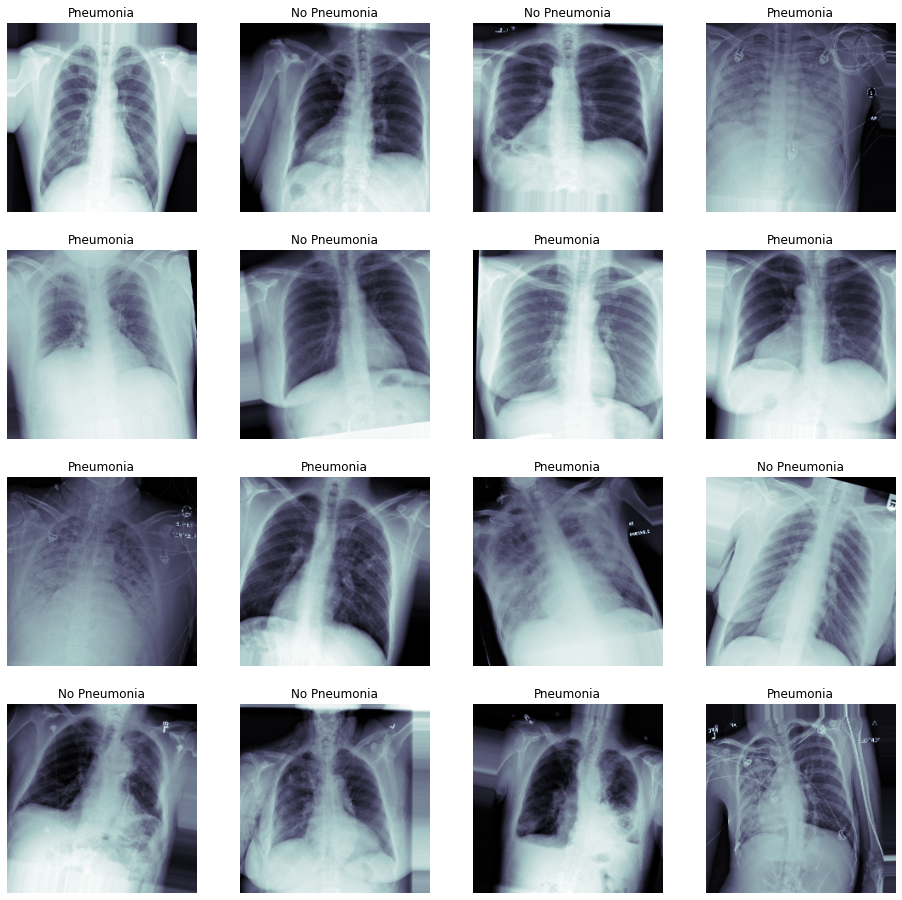

In [14]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

train_gen = make_train_gen(train_data, bat_size=100)
t_x, t_y = next(train_gen)

t_x_mean = valX.mean() 
t_x_std = valX.std() 

print(t_x_mean, t_x_std)

t_x = (t_x - t_x_mean)/ t_x_std

fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

### Defining the CNN model to classify images: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

#### Function to load a pre-trained model

In [15]:
def load_pretrained_model(start_layer = 'block5_pool', trai_lay = 17, print_res=False):
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(start_layer)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    for layer in vgg_model.layers[0:trai_lay]:
        layer.trainable = False
    
    # Todo
    if print_res == True:
        print(model.summary())
        
        for layer in vgg_model.layers:
            print(layer.name, layer.trainable)
        
    return vgg_model


#### Function that creates the model architecture

In [16]:
def build_my_model(Lay1 = 1024, Drop1 = .5, Lay2 = 512, Drop2 = .5, Lay3 =256, Drop3 = .5):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    vgg_model = load_pretrained_model(trai_lay = 18)
    
    my_model = Sequential()
    
    my_model.add(vgg_model)
    
    my_model.add(Flatten())

    my_model.add(Dropout(Drop1))
    
    my_model.add(Dense(Lay1, activation='relu'))
    
    my_model.add(Dropout(Drop2))

    my_model.add(Dense(Lay2, activation='relu'))
    
    my_model.add(Dropout(Drop3))
    
    my_model.add(Dense(Lay3, activation='relu'))
    
    my_model.add(Dense(1, activation='sigmoid'))    
    
    print(my_model.summary())
    
    return my_model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

#### Creating the model

In [17]:
my_model = build_my_model(Lay1 = 1024, Drop1 = .5, Lay2 = 512, Drop2 = .2, Lay3 = 256, Drop3 = .1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

#### Defining the optimizer to train the model

In [18]:
optimizer = Adam(lr=1e-5)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

#### Defining the path to save the model and the log characteristics for the training events

In [19]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.bestBARA".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'binary_accuracy', 
                              verbose=2, 
                              save_best_only=True, 
                              mode= 'max', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'binary_accuracy', 
                       mode= 'max', 
                       patience=25)

callbacks_list = [checkpoint, early]

#### Compiling the model

In [20]:
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

### Training the model

In [21]:
## train your model

with active_session():
    
    history = my_model.fit_generator(train_gen, 
                                validation_data = (valX, valY),                            
                                epochs = 40, 
                                steps_per_epoch = 50,
                                callbacks = callbacks_list)

Epoch 1/40
50/50 [==============================] - 131s 3s/step - loss: 0.7184 - binary_accuracy: 0.4957 - val_loss: 0.6990 - val_binary_accuracy: 0.5128

Epoch 00001: binary_accuracy improved from -inf to 0.49567, saving model to xray_class_my_model.bestBARA
Epoch 2/40
50/50 [==============================] - 120s 2s/step - loss: 0.7017 - binary_accuracy: 0.5285 - val_loss: 0.6806 - val_binary_accuracy: 0.5431

Epoch 00002: binary_accuracy improved from 0.49567 to 0.52845, saving model to xray_class_my_model.bestBARA
Epoch 3/40
50/50 [==============================] - 121s 2s/step - loss: 0.6845 - binary_accuracy: 0.5376 - val_loss: 0.6992 - val_binary_accuracy: 0.5268

Epoch 00003: binary_accuracy improved from 0.52845 to 0.53762, saving model to xray_class_my_model.bestBARA
Epoch 4/40
50/50 [==============================] - 122s 2s/step - loss: 0.6952 - binary_accuracy: 0.5545 - val_loss: 0.6615 - val_binary_accuracy: 0.6131

Epoch 00004: binary_accuracy improved from 0.53762 to 0

50/50 [==============================] - 123s 2s/step - loss: 0.6606 - binary_accuracy: 0.6201 - val_loss: 0.6755 - val_binary_accuracy: 0.5967

Epoch 00035: binary_accuracy did not improve from 0.62042
Epoch 36/40
50/50 [==============================] - 120s 2s/step - loss: 0.6463 - binary_accuracy: 0.6186 - val_loss: 0.6688 - val_binary_accuracy: 0.6131

Epoch 00036: binary_accuracy did not improve from 0.62042
Epoch 37/40
50/50 [==============================] - 124s 2s/step - loss: 0.6493 - binary_accuracy: 0.6145 - val_loss: 0.6639 - val_binary_accuracy: 0.6200

Epoch 00037: binary_accuracy did not improve from 0.62042
Epoch 38/40
50/50 [==============================] - 123s 2s/step - loss: 0.6487 - binary_accuracy: 0.6164 - val_loss: 0.6662 - val_binary_accuracy: 0.6340

Epoch 00038: binary_accuracy did not improve from 0.62042
Epoch 39/40
50/50 [==============================] - 122s 2s/step - loss: 0.6270 - binary_accuracy: 0.6191 - val_loss: 0.6697 - val_binary_accuracy: 0.6

### Performance of the trained model

Note, these figures will come in handy for your FDA documentation later in the project

#### Classifying images to find the performance of the model

In [22]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

429/429 [==============================] - 8s 19ms/step


#### Functions to plot the performance of the model

In [23]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    lw = 2
    fig, c_ax = plt.subplots(1,1, figsize = (7, 7))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--');
    c_ax.legend()
    plt.title("ROC curve");
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    return

## what other performance statistics do you want to include here besides AUC? 


def presc_rec(t_y, t_pre):
    
    fig, c_ax = plt.subplots(1,1, figsize = (7,7))
    Test = precision_recall_curve(t_y, t_pre)
    plt.plot(Test[1], Test[0])
    plt.title("Precision - Racall curve");
    plt.xlabel("Recall");
    plt.ylabel("Precision");
    plt.legend(loc="upper right");    
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    N = len(history.history["loss"])
    plt.figure(figsize=(10,5)) ;
    plt.style.use("ggplot");
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss");
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss");
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc");
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc");
    plt.title("Training Loss and Accuracy on Dataset");
    plt.xlabel("Epoch #");
    plt.ylabel("Loss/Accuracy");
    plt.legend(loc="upper right");
    
    return

#### Plotting training events 

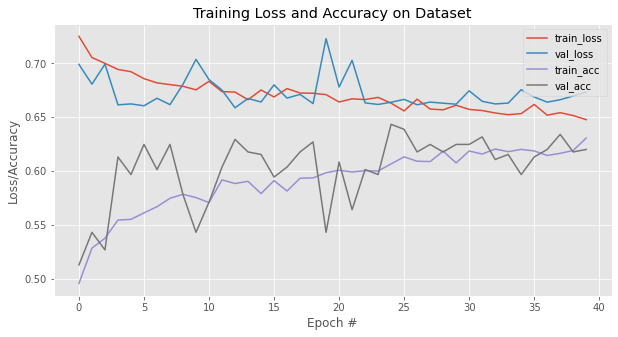

In [24]:
## plot figures
plot_history(history)

#### ROC curve

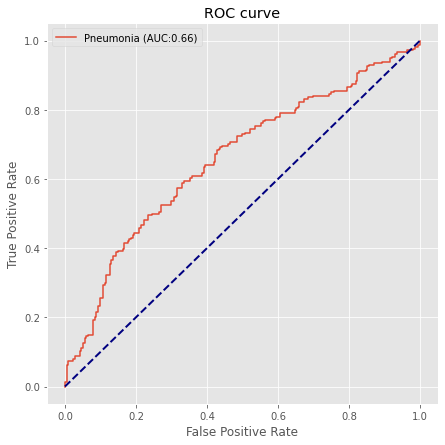

In [25]:
plot_auc(valY, pred_Y)

#### Precision - Recall curve

No handles with labels found to put in legend.


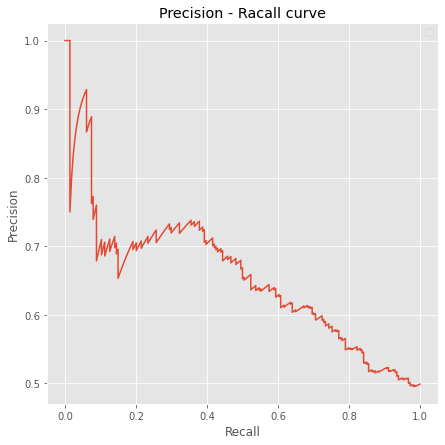

In [26]:
presc_rec(valY, pred_Y)

### Defining the optimal parameter for the classification of images

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

#### Functions to define the optimal threshold

In [27]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

def performance_vs_thresh(pred_Y):
    
    pred_prob = pred_Y
    thresholds = np.linspace(0,1,100)
    
    f1_scores = []
    pre_scores = []
    rec_scores = []
    
    GroupLabels = ['F1', 'Prescision', 'Recall']
    cmap = plt.get_cmap('hsv')
    lines = ['-', '--', '-.']*5
    colors = [cmap(i) for i in np.linspace(0, 1, 14)]    
    
    for thr in thresholds:
        f1_scores.append(f1_score(valY, pred_prob > thr))
        pre_scores.append(precision_score(valY, pred_prob > thr))
        rec_scores.append(recall_score(valY, pred_prob > thr))

    plt.figure(figsize=(12,7))
    plt.plot(thresholds, f1_scores, label = GroupLabels[0]);  
    plt.plot(thresholds, pre_scores, label = GroupLabels[1]);  
    plt.plot(thresholds, rec_scores, label = GroupLabels[2]);      
    
    plt.legend(loc="lower left");
    plt.title('Diseases Vs Population Age')
    plt.xlabel('Threshold')
    plt.ylabel('score')
    plt.grid(True)    

    return [f1_scores, pre_scores, rec_scores]

#### Plotting the classification of images using different thresholds

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


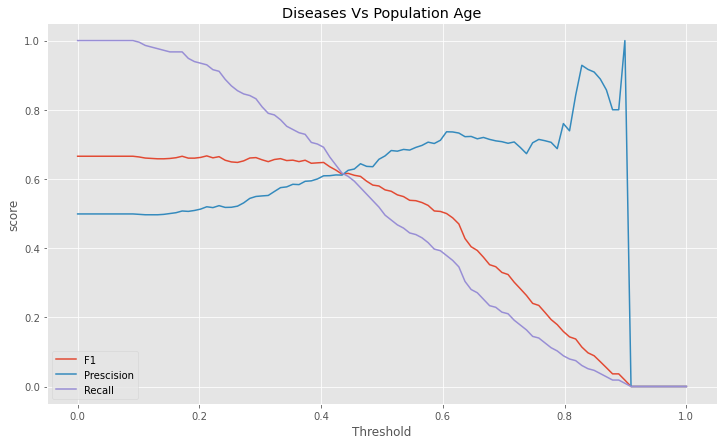

In [28]:
A = performance_vs_thresh(pred_Y)

### Classifying images with the trained model

In [ ]:
## Let's look at some examples of predicted v. true with our best model: 

# Todo
YOUR_THRESHOLD = .5

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], t_y[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

### Saving the trained as a json file

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_modelBARA.json", "w") as json_file:
    json_file.write(model_json)

### Conclusion

It can be concluded that the trained model was able to learn images of cases related to pneumonia. However, its performance is not too high, as was shown in the score curves presented. However, the same curves also showed that the model can be used to determine how positive is an image to be related to pneumonia cases, which is a great help when discarding a possible case. This is possible when using a threshold value of .5 to determine pneumonia cases.

## FIN